# **Medical Imaging (CAMELYON 16) Final Project**

Andy Cho (yc2956) - December 22, 2020

## **Starter Code**

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import shutil

# Bring to the local directory from Google Drive
if not os.path.exists("/content/Medical_Imaging_Files"):
  shutil.move("/content/drive/My Drive/Medical_Imaging_Files", "/content/") 

In [5]:
slide_path_sample = '/content/Medical_Imaging_Files/tumor_031.tif'
tumor_mask_path_sample = '/content/Medical_Imaging_Files/tumor_031_mask.tif'

slide_sample = open_slide(slide_path_sample)
print("Read WSI from %s with width: %d, height: %d" % (slide_path_sample, slide_sample.level_dimensions[0][0], slide_sample.level_dimensions[0][1]))

tumor_mask_sample = open_slide(tumor_mask_path_sample)
print("Read tumor mask from %s" % (tumor_mask_path_sample))

print("Slide includes %d levels", len(slide_sample.level_dimensions))
for i in range(len(slide_sample.level_dimensions)-1): # slide is missing for the last index
    print("Level %d, dimensions: %s downsample factor %d" % (i, slide_sample.level_dimensions[i], slide_sample.level_downsamples[i]))
    assert tumor_mask_sample.level_dimensions[i][0] == slide_sample.level_dimensions[i][0]
    assert tumor_mask_sample.level_dimensions[i][1] == slide_sample.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide_sample.level_dimensions[5]
print(width,height)
assert width * slide_sample.level_downsamples[5] == slide_sample.level_dimensions[0][0]
assert height * slide_sample.level_downsamples[5] == slide_sample.level_dimensions[0][1]

Read WSI from /content/Medical_Imaging_Files/tumor_031.tif with width: 97792, height: 221184
Read tumor mask from /content/Medical_Imaging_Files/tumor_031_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7, dimensions: (764, 1728) downsample factor 128
Level 8, dimensions: (382, 864) downsample factor 256
3056 6912


In [6]:
# Check to make sure all the dimensions are correct
print(slide_sample.level_dimensions)
print(tumor_mask_sample.level_dimensions)

((97792, 221184), (48896, 110592), (24448, 55296), (12224, 27648), (6112, 13824), (3056, 6912), (1528, 3456), (764, 1728), (382, 864), (191, 432))
((97792, 221184), (48896, 110592), (24448, 55296), (12224, 27648), (6112, 13824), (3056, 6912), (1528, 3456), (764, 1728), (382, 864))


## **Helper Functions**

In [7]:
def read_slide(slide, x, y, level, width, height, as_float=False):

  im = slide.read_region((x,y), level, (width, height))
  im = im.convert('RGB') # drop the alpha channel
  if as_float:
    im = np.asarray(im, dtype=np.float32)
  else:
    im = np.asarray(im)
  assert im.shape == (height, width, 3)

  return im

(3456, 1528, 3)


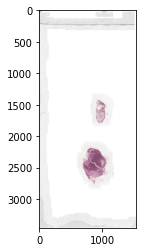

In [8]:
def fetch_slide_image(slide, x, y, level):
  slide_image = read_slide(slide, 
                         x=x, 
                         y=y, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
  
  return slide_image

slide_image_sample = fetch_slide_image(slide_sample, 0, 0, 6)
print(slide_image_sample.shape)

# Sample plot
plt.imshow(slide_image_sample)

184955
184955 tissue_pixels pixels (1.5 percent of the image)


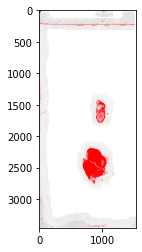

In [9]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_pixels_sample = find_tissue_pixels(slide_image_sample)
print(len(tissue_pixels_sample))
percent_tissue = len(tissue_pixels_sample) / float(slide_image_sample.shape[0] * slide_image_sample.shape[0]) * 100
print("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels_sample), percent_tissue)) 

tissue_regions = apply_mask(slide_image_sample, tissue_pixels_sample)
plt.imshow(tissue_regions)

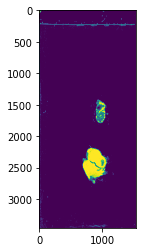

In [10]:
def fetch_tissue_mask_image(slide, x, y, level): # From the slide image / output True for the pixel if tissue

  tissue_mask_image = read_slide(slide, 
                        x=x, 
                        y=y, 
                        level=level, 
                        width=slide.level_dimensions[level][0],
                        height=slide.level_dimensions[level][1])

  tissue_mask_image_gray = rgb2gray(tissue_mask_image)
  tissue_mask_image_bool = tissue_mask_image_gray <= 0.8
  tissue_mask_image = tissue_mask_image_bool.astype(int)

  return tissue_mask_image

tissue_mask_image_sample = fetch_tissue_mask_image(slide_sample, 0, 0, 6)

# Sample plot
plt.imshow(tissue_mask_image_sample)

(3456, 1528)


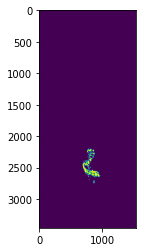

In [11]:
def fetch_tumor_mask_image(tumor_mask, x, y, level): # From the tumor mask image / output 1 where tumor exists

  tumor_mask_image = read_slide(tumor_mask, 
                        x=x, 
                        y=y, 
                        level=level, 
                        width=tumor_mask.level_dimensions[level][0],
                        height=tumor_mask.level_dimensions[level][1])

  tumor_mask_image = tumor_mask_image[:,:,0]
  return tumor_mask_image

tumor_mask_image_sample = fetch_tumor_mask_image(tumor_mask_sample, 0, 0, 6)

# Sample plot
print(tumor_mask_image_sample.shape)
plt.imshow(tumor_mask_image_sample)

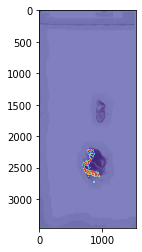

In [12]:
# Overlay them. The idea is that the mask shows the region of the slide that contain cancerous cells.
plt.imshow(slide_image_sample)
plt.imshow(tumor_mask_image_sample, cmap='jet', alpha=0.5) # Red regions contains cancer.

## **Get Training Dataset**

## Divide by Patches

In [20]:
# slide_image = fetch_slide_image(slide, 0, 0, 5) # input to the model
# tissue_mask_image = fetch_tissue_mask_image(slide, 0, 0, 5) # output 1 where tissue exists
# tumor_mask_image = fetch_tumor_mask_image(tumor_mask, 0, 0, 5) # output 1 where tumor exists

In [21]:
# from sklearn.datasets import load_sample_image
# from sklearn.feature_extraction import image

# patches_slide = image.extract_patches_2d(slide_image, 
#                                    (299, 299), 
#                                    max_patches = round(slide_image.shape[0] * slide_image.shape[1] / 299**2),
#                                    random_state = 1234) # include random state so we can match with the tissue_mask_image

# patches_tissue = image.extract_patches_2d(tissue_mask_image, 
#                                    (299, 299), 
#                                    max_patches = round(tissue_mask_image.shape[0] * tissue_mask_image.shape[1] / 299**2),
#                                    random_state = 1234) # include random state so we can match with the tissue_mask_image

# # Only include patches that have enough tissues in the patch (over 10% of the pixels)
# sufficientTissues = []
# for i in range(round(tissue_mask_image.shape[0] * tissue_mask_image.shape[1] / 299**2)):
#   if sum(sum(patches_tissue[i])) > 299**2 / 10:
#     sufficientTissues.append(i)

# patches_slide = patches_slide[sufficientTissues]
# patches_tissue = patches_tissue[sufficientTissues]

# # Random patch to check
# n = round(len(patches_slide)/2)
# plt.imshow(patches_slide[n])

## Prepare the Dataset

In [13]:
slide_paths = ['tumor_023.tif', 'tumor_031.tif', 'tumor_035.tif', 'tumor_101.tif', 'tumor_057.tif',
              'tumor_059.tif', 'tumor_064.tif', 'tumor_075.tif']
               #'tumor_078.tif', 'tumor_081.tif', 'tumor_084.tif', 'tumor_094.tif', 'tumor_096.tif']

tumor_mask_paths = ['tumor_023_mask.tif', 'tumor_031_mask.tif', 'tumor_035_mask.tif', 'tumor_101_mask.tif', 'tumor_057_mask.tif',
                    'tumor_059_mask.tif', 'tumor_064_mask.tif', 'tumor_075_mask.tif']
                    #'tumor_078_mask.tif', 'tumor_081_mask.tif', 'tumor_084_mask.tif', 'tumor_094_mask.tif', 'tumor_096_mask.tif']

In [16]:
def process_images(slide_paths, tumor_mask_paths, level): # Output images by reading files with open_slide

  slide_images = []
  tissue_mask_images = []
  tumor_mask_images = []

  for i in range(len(slide_paths)):

    slide_path = '/content/Medical_Imaging_Files/' + slide_paths[i]
    tumor_mask_path = '/content/Medical_Imaging_Files/' + tumor_mask_paths[i]

    # folder not working
    # slide_url = 'https://storage.googleapis.com/applied-dl/tumor-slides/%s' % slide_path
    # mask_url = 'https://storage.googleapis.com/applied-dl/tumor-slides/%s' % tumor_mask_path

    # # temporary folder
    # slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
    # mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

    # # Download the whole slide image
    # if not os.path.exists(slide_path):
    #   !curl -O $slide_url

    # # Download the tumor mask
    # if not os.path.exists(tumor_mask_path):
    #   !curl -O $mask_url

    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)

    slide_image = fetch_slide_image(slide, 0, 0, level=level)
    tissue_mask_image = fetch_tissue_mask_image(slide, 0, 0, level=level)
    tumor_mask_image = fetch_tumor_mask_image(tumor_mask, 0, 0, level=level)

    slide_images.append(slide_image)
    tissue_mask_images.append(tissue_mask_image)
    tumor_mask_images.append(tumor_mask_image)

  return slide_images, tissue_mask_images, tumor_mask_images

# slide_images, tissue_mask_images, tumor_mask_images = process_images(slide_paths, tumor_mask_paths, level=5)

In [18]:
# Check that we have the same number of images
print(len(slide_images), len(tissue_mask_images),len(tumor_mask_images))

for i in range(8):
  print(slide_images[i].shape)
  print(tissue_mask_images[i].shape)
  print(tumor_mask_images[i].shape)
  print('----------------')

8 8 8
(6912, 3056, 3)
(6912, 3056)
(6912, 3056)
----------------
(6912, 3056, 3)
(6912, 3056)
(6912, 3056)
----------------
(6912, 3056, 3)
(6912, 3056)
(6912, 3056)
----------------
(2240, 4352, 3)
(2240, 4352)
(2240, 4352)
----------------
(6896, 3056, 3)
(6896, 3056)
(6896, 3056)
----------------
(6912, 3040, 3)
(6912, 3040)
(6912, 3040)
----------------
(6896, 3056, 3)
(6896, 3056)
(6896, 3056)
----------------
(2464, 2816, 3)
(2464, 2816)
(2464, 2816)
----------------


In [38]:
from sklearn.feature_extraction import image

def fetch_patches(slide_images, tissue_mask_images, tumor_mask_images, multiplier):

  patches_slide_all = []
  patches_tissue_all = []
  patches_tumor_all = []
  patches_tumor_binary_all = []

  for iter in range(len(slide_images)):

    # Number of patches (assuming no patches overlap, multiplier x that amount (due to memory restrictions))
    n = round(slide_images[iter].shape[0] * slide_images[iter].shape[1] / 299**2) * multiplier

    patches_slide = image.extract_patches_2d(slide_images[iter], 
                                   (299, 299), 
                                   max_patches = n,
                                   random_state = 1234) # include random state so we can match with the tissue_mask_image

    patches_tissue = image.extract_patches_2d(tissue_mask_images[iter], 
                                   (299, 299), 
                                   max_patches = n,
                                   random_state = 1234) # include random state so we can match with the tissue_mask_image

    patches_tumor = image.extract_patches_2d(tumor_mask_images[iter], 
                                   (299, 299), 
                                   max_patches = n,
                                   random_state = 1234) # include random state so we can match with the tissue_mask_image                             

    # Only include patches that have enough tissues in the patch (over 10% of the pixels)
    sufficientTissues = []
    for i in range(n):
      if sum(sum(patches_tissue[i])) > 299**2 / 10:
        sufficientTissues.append(i)

    # Filter out tissues without enough tissues to begin with
    patches_slide = patches_slide[sufficientTissues]
    patches_tissue = patches_tissue[sufficientTissues]
    patches_tumor = patches_tumor[sufficientTissues]

    for patch_slide in patches_slide:
      patches_slide_all.append(patch_slide)
    for patch_tissue in patches_tissue:
      patches_tissue_all.append(patch_tissue)
    for patch_tumor in patches_tumor:
      patches_tumor_all.append(patch_tumor)
      cancer = sum(sum(patch_tumor))
      if cancer > 0:
        patches_tumor_binary_all.append([1,0]) # cancer is [1,0]
      else:
        patches_tumor_binary_all.append([0,1]) # cancer-free is [0,1]

  patches_slide_all = np.array(patches_slide_all)
  patches_tissue_all = np.array(patches_tissue_all)
  patches_tumor_all = np.array(patches_tumor_all)
  patches_tumor_binary_all = np.array(patches_tumor_binary_all)

  return patches_slide_all, patches_tissue_all, patches_tumor_all, patches_tumor_binary_all

# patches_slide_all, patches_tissue_all, patches_tumor_all, patches_tumor_binary_all = fetch_patches(slide_images, tissue_mask_images, tumor_mask_images)


In [39]:
# Save the 299x299 patches in local folders
from PIL import Image  
import PIL  
import random

def saveLocally(patches_slide_all, patches_tumor_binary_all, level, train_proportion):

  n = len(patches_slide_all)
  train_indices = random.sample([i for i in range(n)], round(n*train_proportion))
  test_indices = list(set([i for i in range(n)]) - set(train_indices))

  for i in range(n):
    if i in set(train_indices):
      if patches_tumor_binary_all[i][0] == 0: # cancer free
        img = Image.fromarray(patches_slide_all[i], 'RGB')
        img.save('/content/drive/MyDrive/Medical_Imaging_Dataset_L' + str(level) + '/train/normal/train_normal' + str(i) + '_level' + str(level) + '.png')
      elif patches_tumor_binary_all[i][0] == 1: # tumor
        img = Image.fromarray(patches_slide_all[i], 'RGB')
        img.save('/content/drive/MyDrive/Medical_Imaging_Dataset_L' + str(level) + '/train/tumor/train_tumor' + str(i) + '_level' + str(level)+ '.png')

    else:
      if patches_tumor_binary_all[i][0] == 0:
        img = Image.fromarray(patches_slide_all[i], 'RGB')
        img.save('/content/drive/MyDrive/Medical_Imaging_Dataset_L' + str(level) + '/test/normal/test_normal' + str(i) + '_level' + str(level)+ '.png')
      elif patches_tumor_binary_all[i][0] == 1:
        img = Image.fromarray(patches_slide_all[i], 'RGB')
        img.save('/content/drive/MyDrive/Medical_Imaging_Dataset_L' + str(level) + '/test/tumor/test_tumor' + str(i) + '_level' + str(level)+ '.png')

# saveLocally(patches_slide_all, patches_tumor_binary_all, level=5, train_proportion=0.8)


In [22]:
print('# training normal images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset/train/normal')))
print('# training tumor images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset/train/tumor')))
print('# testing normal images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset/test/normal')))
print('# testing tumor images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset/test/tumor')))

# training normal images: 727
# training tumor images: 243
# testing normal images: 188
# testing tumor images: 54


In [26]:
import keras
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Medical_Imaging_Dataset/train',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Medical_Imaging_Dataset/test',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')

Found 970 images belonging to 2 classes.
Found 242 images belonging to 2 classes.


## **Modeling**

In [27]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [211]:
import tensorflow as tf

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(299,299,3),
    pooling='max',
    classes=1000
)

model = tf.keras.Sequential()
model.add(base_model) # Original model
model.add(tf.keras.layers.Flatten())

# Transfer learning
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='selu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [212]:
history = model.fit(train_generator, epochs=8, validation_data=test_generator)

Epoch 1/8
61/61 [==============================] - 15s 148ms/step - loss: 3.5205 - accuracy: 0.6370 - val_loss: 0.6797 - val_accuracy: 0.7769
Epoch 2/8
61/61 [==============================] - 8s 131ms/step - loss: 1.0942 - accuracy: 0.6951 - val_loss: 0.6207 - val_accuracy: 0.7769
Epoch 3/8
61/61 [==============================] - 8s 132ms/step - loss: 0.7145 - accuracy: 0.7175 - val_loss: 0.5401 - val_accuracy: 0.7769
Epoch 4/8
61/61 [==============================] - 8s 136ms/step - loss: 0.7156 - accuracy: 0.7307 - val_loss: 0.5724 - val_accuracy: 0.7769
Epoch 5/8
61/61 [==============================] - 8s 131ms/step - loss: 0.5441 - accuracy: 0.7679 - val_loss: 0.6526 - val_accuracy: 0.7066
Epoch 6/8
61/61 [==============================] - 8s 131ms/step - loss: 0.6045 - accuracy: 0.7373 - val_loss: 0.5296 - val_accuracy: 0.7769
Epoch 7/8
61/61 [==============================] - 8s 131ms/step - loss: 0.4754 - accuracy: 0.7673 - val_loss: 0.5110 - val_accuracy: 0.7934
Epoch 8/8
61

In [213]:
# Non-transfer learning technique
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Conv2D(16, (8, 8), activation='relu', padding = 'valid', input_shape=(299, 299, 3)))
model2.add(tf.keras.layers.MaxPooling2D((4, 4)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(256, activation='selu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()
model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics='accuracy')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 292, 292, 16)      3088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 85264)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               10913920  
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

In [214]:
history2 = model2.fit(train_generator, 
                              epochs=8, 
                              validation_data=test_generator)

Epoch 1/8
61/61 [==============================] - 7s 111ms/step - loss: 1.8700 - accuracy: 0.6819 - val_loss: 0.5403 - val_accuracy: 0.7769
Epoch 2/8
61/61 [==============================] - 6s 104ms/step - loss: 0.5512 - accuracy: 0.7485 - val_loss: 0.5394 - val_accuracy: 0.7769
Epoch 3/8
61/61 [==============================] - 6s 106ms/step - loss: 0.5723 - accuracy: 0.7194 - val_loss: 0.5310 - val_accuracy: 0.7769
Epoch 4/8
61/61 [==============================] - 7s 116ms/step - loss: 0.5595 - accuracy: 0.7452 - val_loss: 0.5326 - val_accuracy: 0.7769
Epoch 5/8
61/61 [==============================] - 6s 105ms/step - loss: 0.5683 - accuracy: 0.7349 - val_loss: 0.5314 - val_accuracy: 0.7769
Epoch 6/8
61/61 [==============================] - 6s 102ms/step - loss: 0.5702 - accuracy: 0.7284 - val_loss: 0.5391 - val_accuracy: 0.7769
Epoch 7/8
61/61 [==============================] - 6s 102ms/step - loss: 0.5335 - accuracy: 0.7472 - val_loss: 0.5294 - val_accuracy: 0.7769
Epoch 8/8
61/

We were able to reach a slightly higher validation accuracy with the ResNet50 model (transfer learning), than our custom model, so when we build our final model, we will train 3 different levels (4,5,6) with ResNet50 and combine for the final prediction.

## **Final Model**

Now that we have completed a pipeline for 1 zoom level, let us train a model for zoom levels 4, 5, 6, and 7 and combine for a final version of the model.

In [37]:
# Remove the files and folders from above
!rm -rf '/content/drive/MyDrive/Medical_Imaging_Dataset/test/normal'
!rm -rf '/content/drive/MyDrive/Medical_Imaging_Dataset/test/tumor'
!rm -rf '/content/drive/MyDrive/Medical_Imaging_Dataset/train/normal'
!rm -rf '/content/drive/MyDrive/Medical_Imaging_Dataset/train/tumor'

## *Level 4*

In [29]:
slide_images_L4, tissue_mask_images_L4, tumor_mask_images_L4 = process_images(slide_paths, tumor_mask_paths, level=4)

In [30]:
patches_slide_all_L4, patches_tissue_all_L4, patches_tumor_all_L4, patches_tumor_binary_all_L4 = fetch_patches(slide_images_L4, 
                                                                                                   tissue_mask_images_L4, 
                                                                                                   tumor_mask_images_L4,
                                                                                                   multiplier=4)

In [31]:
import gc
gc.collect()

# Save memory!
del slide_images_L4
del tissue_mask_images_L4
del tumor_mask_images_L4

In [33]:
saveLocally(patches_slide_all_L4, patches_tumor_binary_all_L4, level=4, train_proportion=0.9)

In [40]:
print('# training normal images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L4/train/normal')))
print('# training tumor images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L4/train/tumor')))
print('# testing normal images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L4/test/normal')))
print('# testing tumor images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L4/test/tumor')))

# training normal images: 2260
# training tumor images: 403
# testing normal images: 251
# testing tumor images: 45


In [35]:
import keras
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_L4 = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Medical_Imaging_Dataset_L4/train',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')

test_generator_L4 = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Medical_Imaging_Dataset_L4/test',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')

Found 2663 images belonging to 2 classes.
Found 296 images belonging to 2 classes.


In [36]:
import tensorflow as tf

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(299,299,3),
    pooling='avg',
    classes=1000
)

model_L4 = tf.keras.Sequential()
model_L4.add(base_model) # Original model
model_L4.add(tf.keras.layers.Flatten())

# Transfer learning
model_L4.add(tf.keras.layers.Dense(256, activation='relu'))
model_L4.add(tf.keras.layers.Dropout(0.2))
model_L4.add(tf.keras.layers.Dense(256, activation='selu'))
model_L4.add(tf.keras.layers.Dropout(0.2))
model_L4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_L4.summary()
model_L4.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [37]:
history_L4 = model_L4.fit(train_generator_L4, 
                              epochs=8, 
                              validation_data=test_generator_L4)

Epoch 1/8
167/167 [==============================] - 32s 129ms/step - loss: 0.7793 - accuracy: 0.8013 - val_loss: 0.4925 - val_accuracy: 0.8480
Epoch 2/8
167/167 [==============================] - 20s 120ms/step - loss: 0.4111 - accuracy: 0.8609 - val_loss: 0.5510 - val_accuracy: 0.8480
Epoch 3/8
167/167 [==============================] - 20s 120ms/step - loss: 0.3713 - accuracy: 0.8624 - val_loss: 0.7240 - val_accuracy: 0.8480
Epoch 4/8
167/167 [==============================] - 20s 119ms/step - loss: 0.3504 - accuracy: 0.8679 - val_loss: 0.3150 - val_accuracy: 0.8649
Epoch 5/8
167/167 [==============================] - 20s 119ms/step - loss: 0.3178 - accuracy: 0.8883 - val_loss: 0.5314 - val_accuracy: 0.6959
Epoch 6/8
167/167 [==============================] - 20s 119ms/step - loss: 0.3125 - accuracy: 0.8872 - val_loss: 0.4045 - val_accuracy: 0.8547
Epoch 7/8
167/167 [==============================] - 20s 119ms/step - loss: 0.3174 - accuracy: 0.8878 - val_loss: 0.4744 - val_accuracy:

## *Level 5*

In [41]:
slide_images_L5, tissue_mask_images_L5, tumor_mask_images_L5 = process_images(slide_paths, tumor_mask_paths, level=5)

In [42]:
patches_slide_all_L5, patches_tissue_all_L5, patches_tumor_all_L5, patches_tumor_binary_all_L5 = fetch_patches(slide_images_L5, 
                                                                                                   tissue_mask_images_L5, 
                                                                                                   tumor_mask_images_L5,
                                                                                                   multiplier=8)

In [43]:
import gc
gc.collect()

# Save memory!
del slide_images_L5
del tissue_mask_images_L5
del tumor_mask_images_L5

In [44]:
saveLocally(patches_slide_all_L5, patches_tumor_binary_all_L5, level=5, train_proportion=0.9)

In [45]:
print('# training normal images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L5/train/normal')))
print('# training tumor images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L5/train/tumor')))
print('# testing normal images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L5/test/normal')))
print('# testing tumor images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L5/test/tumor')))

# training normal images: 1292
# training tumor images: 438
# testing normal images: 144
# testing tumor images: 48


In [46]:
import keras
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_L5 = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Medical_Imaging_Dataset_L5/train',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')

test_generator_L5 = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Medical_Imaging_Dataset_L5/test',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')

Found 1730 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


In [47]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(299,299,3),
    pooling='avg',
    classes=1000
)

model_L5 = tf.keras.Sequential()
model_L5.add(base_model) # Original model
model_L5.add(tf.keras.layers.Flatten())

# Transfer learning
model_L5.add(tf.keras.layers.Dense(256, activation='relu'))
model_L5.add(tf.keras.layers.Dropout(0.2))
model_L5.add(tf.keras.layers.Dense(256, activation='selu'))
model_L5.add(tf.keras.layers.Dropout(0.2))
model_L5.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_L5.summary()
model_L5.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [48]:
history_L5 = model_L5.fit(train_generator_L5, 
                              epochs=8, 
                              validation_data=test_generator_L5)

Epoch 1/8
109/109 [==============================] - 20s 131ms/step - loss: 1.0454 - accuracy: 0.6983 - val_loss: 0.6112 - val_accuracy: 0.7500
Epoch 2/8
109/109 [==============================] - 13s 119ms/step - loss: 0.5441 - accuracy: 0.7584 - val_loss: 0.5453 - val_accuracy: 0.7552
Epoch 3/8
109/109 [==============================] - 13s 119ms/step - loss: 0.4686 - accuracy: 0.7888 - val_loss: 0.5746 - val_accuracy: 0.7604
Epoch 4/8
109/109 [==============================] - 13s 119ms/step - loss: 0.4852 - accuracy: 0.7852 - val_loss: 0.5966 - val_accuracy: 0.7500
Epoch 5/8
109/109 [==============================] - 13s 119ms/step - loss: 0.4845 - accuracy: 0.7716 - val_loss: 0.7900 - val_accuracy: 0.7865
Epoch 6/8
109/109 [==============================] - 13s 119ms/step - loss: 0.4623 - accuracy: 0.7860 - val_loss: 0.6516 - val_accuracy: 0.7760
Epoch 7/8
109/109 [==============================] - 13s 119ms/step - loss: 0.4669 - accuracy: 0.7659 - val_loss: 1.3246 - val_accuracy:

## *Level 6*

In [56]:
slide_images_L6, tissue_mask_images_L6, tumor_mask_images_L6 = process_images(slide_paths, tumor_mask_paths, level=6)

In [57]:
patches_slide_all_L6, patches_tissue_all_L6, patches_tumor_all_L6, patches_tumor_binary_all_L6 = fetch_patches(slide_images_L6, 
                                                                                                   tissue_mask_images_L6, 
                                                                                                   tumor_mask_images_L6,
                                                                                                   multiplier=30)

In [58]:
import gc
gc.collect()

# Save memory!
del slide_images_L6
del tissue_mask_images_L6
del tumor_mask_images_L6

In [59]:
saveLocally(patches_slide_all_L6, patches_tumor_binary_all_L6, level=6, train_proportion=0.9)

In [60]:
print('# training normal images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L6/train/normal')))
print('# training tumor images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L6/train/tumor')))
print('# testing normal images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L6/test/normal')))
print('# testing tumor images:', len(os.listdir('/content/drive/MyDrive/Medical_Imaging_Dataset_L6/test/tumor')))

# training normal images: 1211
# training tumor images: 1003
# testing normal images: 148
# testing tumor images: 98


In [66]:
import keras
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_L6 = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Medical_Imaging_Dataset_L6/train',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')

test_generator_L6 = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Medical_Imaging_Dataset_L6/test',
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')

Found 2214 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [69]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(299,299,3),
    pooling='avg',
    classes=1000
)

model_L6 = tf.keras.Sequential()
model_L6.add(base_model) # Original model
model_L6.add(tf.keras.layers.Flatten())

# Transfer learning
model_L6.add(tf.keras.layers.Dense(64, activation='selu'))
#model_L6.add(tf.keras.layers.Dropout(0.2))
model_L6.add(tf.keras.layers.Dense(64, activation='selu'))
#model_L6.add(tf.keras.layers.Dropout(0.2))
model_L6.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_L6.summary()
model_L6.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 23,723,073
Trainable params: 23,669,953
Non-trainable params: 53,120
_________________________________________________________________


In [70]:
history_L6 = model_L6.fit(train_generator_L6, 
                              epochs=8, 
                              validation_data=test_generator_L6)

Epoch 1/8
139/139 [==============================] - 23s 126ms/step - loss: 1.0604 - accuracy: 0.6486 - val_loss: 0.9318 - val_accuracy: 0.6016
Epoch 2/8
139/139 [==============================] - 17s 118ms/step - loss: 0.4986 - accuracy: 0.7778 - val_loss: 5.7133 - val_accuracy: 0.4512
Epoch 3/8
139/139 [==============================] - 17s 120ms/step - loss: 0.4770 - accuracy: 0.7906 - val_loss: 12.0658 - val_accuracy: 0.3984
Epoch 4/8
139/139 [==============================] - 17s 118ms/step - loss: 0.4440 - accuracy: 0.7985 - val_loss: 0.5651 - val_accuracy: 0.7927
Epoch 5/8
139/139 [==============================] - 16s 118ms/step - loss: 0.4133 - accuracy: 0.8113 - val_loss: 1.0343 - val_accuracy: 0.4106
Epoch 6/8
139/139 [==============================] - 17s 118ms/step - loss: 0.3751 - accuracy: 0.8387 - val_loss: 1.7557 - val_accuracy: 0.4024
Epoch 7/8
139/139 [==============================] - 17s 118ms/step - loss: 0.3775 - accuracy: 0.8357 - val_loss: 0.6185 - val_accuracy

In [72]:
# Save the models
model_L4.save("model_L4")
model_L5.save("model_L5")
model_L6.save("model_L6")

INFO:tensorflow:Assets written to: model_L4/assets
INFO:tensorflow:Assets written to: model_L5/assets
INFO:tensorflow:Assets written to: model_L6/assets


In [75]:
!zip -r /content/model_L6.zip /content/model_L6

  adding: content/model_L6/ (stored 0%)
  adding: content/model_L6/assets/ (stored 0%)
  adding: content/model_L6/variables/ (stored 0%)
  adding: content/model_L6/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_L6/variables/variables.index (deflated 80%)
  adding: content/model_L6/saved_model.pb (deflated 93%)


In [ ]:
from google.colab import files
files.download("/content/file.zip")